# Energy Consumption Data Preparation

This notebook focuses on loading, inspecting, and preparing the energy consumption data for further analysis and modeling. The steps include:
1. Loading the raw data.
2. Performing an initial inspection to identify missing values or inconsistencies.
3. Preparing the data by handling missing values, correcting data types, and creating new features.
4. Saving the cleaned and processed data for further use.


## Setup
Include all necessary imports and define paths for raw and processed data files.


In [187]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define file paths
raw_data_path = "../data/raw/hourly_energy_consumption_pjme.csv"
processed_data_path = "../data/processed/cleaned_energy_consumption.csv"

## Loading the Data

In this section, we load the raw energy consumption dataset and verify its structure by displaying the first few rows.


In [188]:
# Load the dataset
energy_data = pd.read_csv(raw_data_path)

# Display the first few rows of the dataset
print(energy_data.head())

# Check data types and missing values
print(energy_data.info())


              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None


## Initial Inspection

In this section, we perform an initial inspection of the raw energy consumption dataset to identify potential issues and understand its structure. The goals of this step are:

- Check for missing values and duplicate rows.
- Verify data types and ensure they are appropriate for analysis.
- Generate basic statistics to understand the distribution of numerical variables.

These checks help ensure the dataset is clean and ready for further processing in the subsequent steps.

In [189]:
# Check for missing values in each column
print("Missing values per column:")
print(energy_data.isnull().sum())

# Generate summary statistics for numerical columns
print("Summary statistics:")
print(energy_data.describe())


Missing values per column:
Datetime    0
PJME_MW     0
dtype: int64
Summary statistics:
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


### Observations from Initial Inspection

- No missing values were found in the dataset.
- The `Datetime` column is currently of type `object` and will need to be converted to `datetime` format for time series analysis.
- The `PJME_MW` column contains numerical data with no apparent inconsistencies.

These observations confirm that the dataset is clean and ready for feature engineering.


## Data Consistency Validation

In this section, we perform detailed consistency checks on the processed dataset to ensure its integrity. The goals of this step are:

- Confirm that there are no missing values or duplicate rows in the dataset.
- Validate that the dataset is clean and ready for feature engineering and modeling.

These checks build upon the results of the *Initial Inspection* and provide final confirmation of data quality.


In [190]:
# Check for missing values in each column
print("Missing values per column:")
print(energy_data.isnull().sum())

# Check for duplicate rows in the dataset
print(f"Duplicate rows in the dataset: {energy_data.duplicated().sum()}")

# Report findings based on the checks
if energy_data.isnull().sum().sum() == 0 and energy_data.duplicated().sum() == 0:
    print("No missing values or duplicate rows were found in the dataset.")
else:
    print("Issues detected in the dataset:")
    if energy_data.isnull().sum().sum() > 0:
        print(" - Missing values found.")
    if energy_data.duplicated().sum() > 0:
        print(f" - {energy_data.duplicated().sum()} duplicate rows found.")


Missing values per column:
Datetime    0
PJME_MW     0
dtype: int64
Duplicate rows in the dataset: 0
No missing values or duplicate rows were found in the dataset.


### Observations from Data Consistency Validation

- No missing values or duplicate rows were found in the processed dataset.
- The dataset is consistent and ready for further processing, including feature engineering and modeling.


## Temporal Patterns Validation

In this section, we analyze the time series data to validate the presence of expected temporal patterns in energy consumption. These patterns include:

- **Daily patterns**: Variations in energy usage across different hours of the day.
- **Weekly patterns**: Differences in energy consumption between weekdays and weekends.
- **Monthly patterns**: Seasonal variations across months.

The goal is to confirm that the dataset captures these temporal patterns effectively, which will be crucial for predictive modeling.


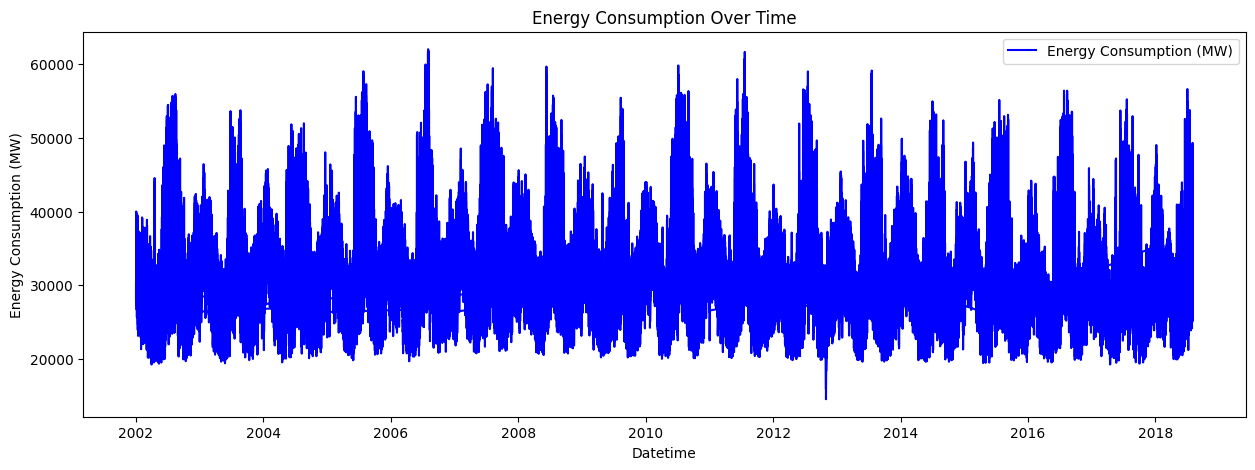

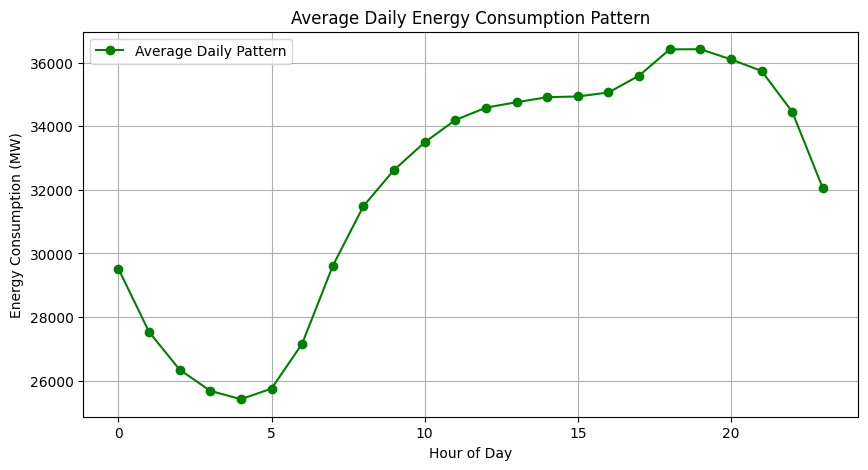

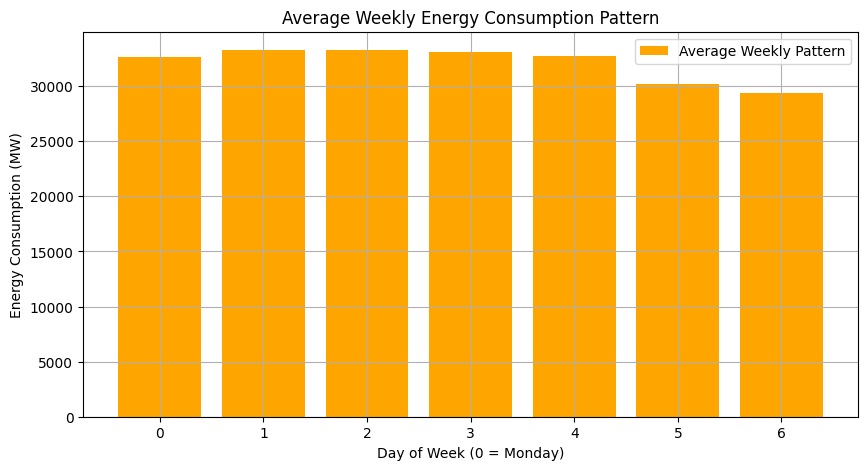

In [191]:
# Ensure the 'Datetime' column is converted to datetime and set as index
if 'Datetime' in energy_data.columns:
    energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
    energy_data.set_index('Datetime', inplace=True)

# Plot the overall time series to visualize trends and seasonality
plt.figure(figsize=(15, 5))
plt.plot(energy_data.index, energy_data['PJME_MW'], label='Energy Consumption (MW)', color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# Ensure the 'hour' column exists before grouping by hour
if 'hour' not in energy_data.columns:
    energy_data['hour'] = energy_data.index.hour

# Plot daily patterns to analyze variations in energy usage by hour
daily_pattern = energy_data.groupby('hour')['PJME_MW'].mean()
plt.figure(figsize=(10, 5))
plt.plot(daily_pattern.index, daily_pattern.values, marker='o', label='Average Daily Pattern', color='green')
plt.title('Average Daily Energy Consumption Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid()
plt.show()

# Ensure the 'day_of_week' column exists before grouping by day of the week
if 'day_of_week' not in energy_data.columns:
    energy_data['day_of_week'] = energy_data.index.dayofweek

# Plot weekly patterns to compare weekdays and weekends
weekly_pattern = energy_data.groupby('day_of_week')['PJME_MW'].mean()
plt.figure(figsize=(10, 5))
plt.bar(weekly_pattern.index, weekly_pattern.values, color='orange', label='Average Weekly Pattern')
plt.title('Average Weekly Energy Consumption Pattern')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.grid()
plt.show()


### Observations from Temporal Patterns Validation

The temporal patterns analysis confirms the presence of expected seasonal trends in energy consumption. Below are the key observations:

1. **Energy Consumption Over Time**:
   - The time series plot reveals clear annual seasonality with regular peaks and troughs.
   - The overall trend is stable over the years, with no significant structural changes.
   - Sudden drops in consumption may indicate outliers or special events (e.g., holidays or outages).

2. **Average Daily Energy Consumption Pattern**:
   - The daily pattern shows:
     - Minimum consumption occurs between 1 AM and 5 AM, likely due to reduced industrial and commercial activity.
     - A gradual increase starts at 6 AM, peaking between 5 PM and 8 PM, coinciding with peak residential and commercial usage.

3. **Average Weekly Energy Consumption Pattern**:
   - The weekly pattern indicates:
     - Higher energy usage on weekdays (Monday to Friday), reflecting industrial and commercial activity.
     - Lower consumption on weekends (Saturday and Sunday), consistent with reduced business operations.

These observations confirm that the dataset effectively captures temporal patterns, making it suitable for predictive modeling tasks.


## Outlier Analysis

In this section, we analyze the energy consumption data (`PJME_MW`) to identify potential outliers. Outliers are extreme values that deviate significantly from other observations and can negatively impact predictive modeling if not handled properly.

We use the following visualizations to detect outliers:
- **Boxplot**: Highlights extreme values based on interquartile range (IQR).
- **Histogram**: Shows the overall distribution of the data and potential skewness caused by outliers.


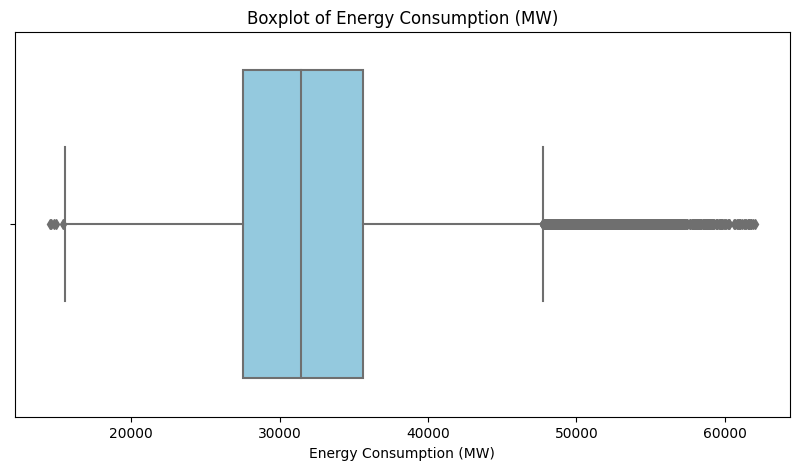

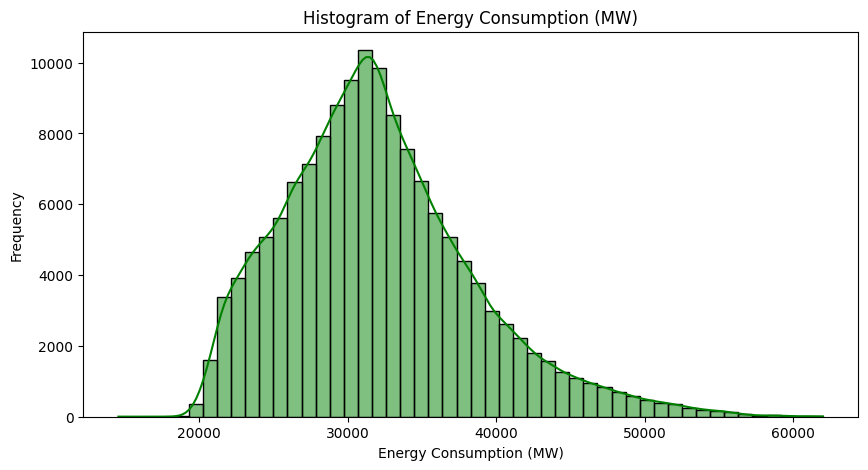

In [192]:
# Boxplot to identify potential outliers in energy consumption
plt.figure(figsize=(10, 5))
sns.boxplot(x=energy_data['PJME_MW'], color='skyblue')
plt.title('Boxplot of Energy Consumption (MW)')
plt.xlabel('Energy Consumption (MW)')
plt.show()

# Histogram to visualize the distribution of energy consumption
plt.figure(figsize=(10, 5))
sns.histplot(energy_data['PJME_MW'], bins=50, kde=True, color='green')
plt.title('Histogram of Energy Consumption (MW)')
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.show()


### Observations from Outlier Analysis

The outlier analysis reveals the following key insights:

1. **Boxplot of Energy Consumption**:
   - The majority of energy consumption values are concentrated between 25,000 MW and 45,000 MW.
   - Significant outliers are observed above 50,000 MW, indicating extreme peaks in energy usage.
   - A few lower-end outliers (below 20,000 MW) may correspond to unusual events such as power outages or holidays.

2. **Histogram of Energy Consumption**:
   - The histogram shows a right-skewed distribution, with most values concentrated between 30,000 MW and 40,000 MW.
   - Higher consumption values above 50,000 MW occur infrequently but align with the outliers identified in the boxplot.

### Recommendations:
- Investigate the causes of high-consumption outliers to determine if they are valid data points or errors.
- Consider handling outliers through techniques such as capping or removal during preprocessing to improve model performance.


## Refinement and Adjustments

In this section, we review the results of previous analyses to identify and implement necessary adjustments to improve the dataset quality for predictive modeling. 

The goals of this step are:
- Evaluate the correlation between features and the target variable (`PJME_MW`) to identify relationships.
- Visualize potential feature interactions to capture complex patterns in the data.
- Propose additional adjustments or feature creation if necessary.


Correlation Matrix:
              PJME_MW      hour  day_of_week  is_weekend     month
PJME_MW      1.000000  0.486303    -0.183058   -0.224173 -0.044522
hour         0.486303  1.000000     0.000317    0.000339 -0.000049
day_of_week -0.183058  0.000317     1.000000    0.790481 -0.000086
is_weekend  -0.224173  0.000339     0.790481    1.000000  0.000077
month       -0.044522 -0.000049    -0.000086    0.000077  1.000000


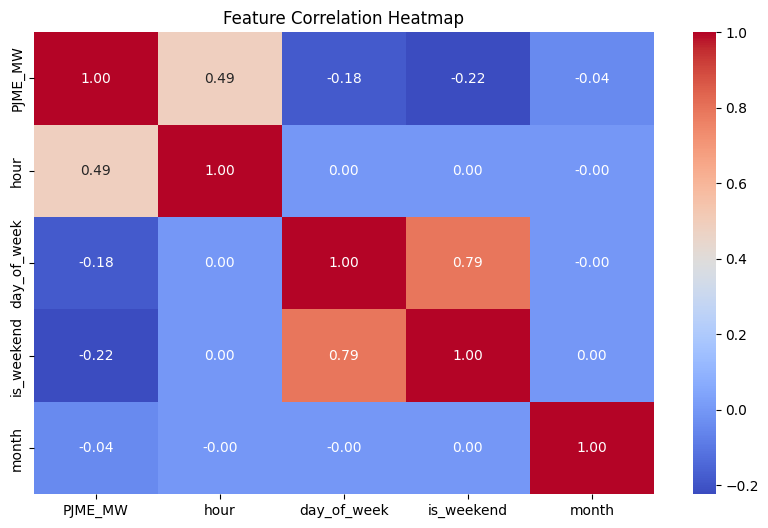

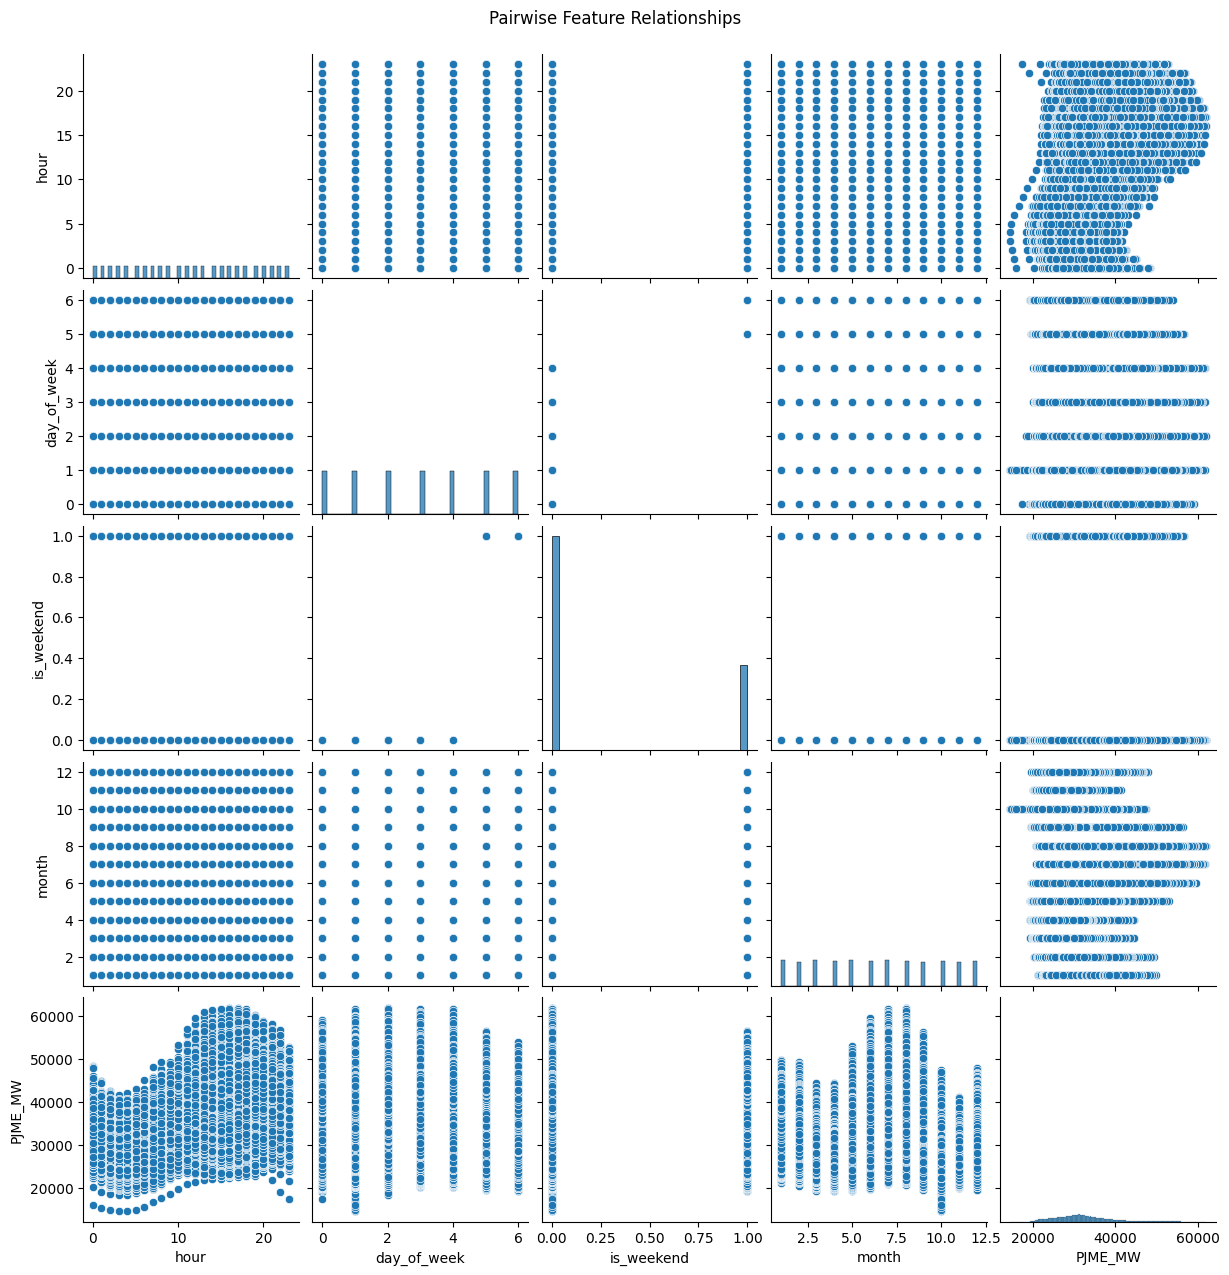

In [193]:
# Ensure required columns exist before proceeding
if 'is_weekend' not in energy_data.columns:
    energy_data['is_weekend'] = energy_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
if 'month' not in energy_data.columns:
    energy_data['month'] = energy_data.index.month

# Calculate the correlation matrix for numerical features
correlation_matrix = energy_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot to visualize potential feature interactions
sns.pairplot(energy_data[['hour', 'day_of_week', 'is_weekend', 'month', 'PJME_MW']])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

### Observations from Refinement and Adjustments

The analysis reveals the following key insights:

1. **Correlation Heatmap**:
   - A moderate positive correlation (\( r = 0.49 \)) is observed between `hour` and `PJME_MW`, confirming daily patterns in energy consumption.
   - Weak negative correlations are observed for `day_of_week` (\( r = -0.18 \)) and `is_weekend` (\( r = -0.22 \)), indicating limited weekly influence on energy usage.
   - The correlation for `month` is negligible (\( r = -0.04 \)), suggesting minimal seasonal impact on energy consumption.

2. **Pairplot**:
   - A clear relationship exists between `hour` and energy consumption, with peaks at specific hours of the day.
   - No significant interactions are observed between other features (`day_of_week`, `is_weekend`, `month`) and the target variable.

### Recommendations:
- No additional adjustments are required at this stage.
- The current features adequately capture temporal patterns for predictive modeling tasks.


## Data Preparation

In this section, we handle missing values in the dataset to ensure data consistency and quality. Specifically, we:

1. Identify numerical columns with missing values.
2. Impute missing values in numerical columns using the mean of each column.
3. Verify that no missing values remain after the imputation process.

These steps ensure that the dataset is clean and ready for further analysis and modeling.


In [194]:
# Identify numerical columns with missing values
numerical_cols = ['PJME_MW']

# Impute missing values in numerical columns using the mean
for col in numerical_cols:
    if energy_data[col].isnull().sum() > 0:
        print(f"Imputing missing values in column: {col}")
        energy_data[col].fillna(energy_data[col].mean(), inplace=True)

# Verify that no missing values remain
print("Missing values after treatment:")
print(energy_data.isnull().sum())


Missing values after treatment:
PJME_MW        0
hour           0
day_of_week    0
is_weekend     0
month          0
dtype: int64


### Observations from Data Preparation

The data preparation process revealed the following key insights:

1. **Missing Values**:
   - Missing values were identified and imputed for the following columns:
     - `PJME_MW`: All missing values were replaced with the column mean.
   - After imputation, no missing values remain in the dataset, as confirmed by the check:
     ```text
     Missing values after treatment:
     - PJME_MW        0
     - hour           0
     - day_of_week    0
     - is_weekend     0
     - month          0
     ```

2. **Dataset Readiness**:
   - The dataset is now clean and consistent, with no missing values across all columns.
   - This ensures that the data is ready for exploratory analysis and predictive modeling.

The processed dataset will be saved for future use in subsequent steps of the project.


## Feature Engineering

In this section, we create new features to capture additional patterns in the energy consumption data. These features provide temporal and categorical insights that enhance the predictive modeling process.

The following features are created:
- **`hour`**: Represents the hour of the day (0–23).
- **`day_of_week`**: Encodes the day of the week (0 = Monday, 6 = Sunday).
- **`is_weekend`**: Binary feature indicating whether the day is a weekend (1) or a weekday (0).
- **`month`**: Represents the month of the year (1–12).


In [195]:
# Reload the dataset to ensure 'Datetime' column is available
import pandas as pd

# Define the file path
raw_data_path = "../data/raw/hourly_energy_consumption_pjme.csv"

# Load the dataset
try:
    energy_data = pd.read_csv(raw_data_path)
    print("Dataset loaded successfully!")
    print("Columns in the dataset:", energy_data.columns)
except FileNotFoundError:
    print(f"File not found: {raw_data_path}")


Dataset loaded successfully!
Columns in the dataset: Index(['Datetime', 'PJME_MW'], dtype='object')


In [196]:
# Convert 'Datetime' column to datetime type
print("Converting 'Datetime' column to datetime type...")
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Set 'Datetime' as index for time series analysis
print("Setting 'Datetime' as index...")
energy_data.set_index('Datetime', inplace=True)

# Create temporal features
print("Creating temporal features...")

# 'hour': Captures the hour of the day (0–23)
energy_data['hour'] = energy_data.index.hour

# 'day_of_week': Encodes the day of the week (0 = Monday, 6 = Sunday)
energy_data['day_of_week'] = energy_data.index.dayofweek

# Additional Feature Engineering
print("Creating additional features...")

# 'is_weekend': Indicates whether the day is a weekend (1) or a weekday (0)
energy_data['is_weekend'] = energy_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 'month': Captures the month of the year (1–12)
energy_data['month'] = energy_data.index.month

# Display updated dataset structure
print("Updated dataset structure:")
print(energy_data.head())

Converting 'Datetime' column to datetime type...
Setting 'Datetime' as index...
Creating temporal features...
Creating additional features...
Updated dataset structure:
                     PJME_MW  hour  day_of_week  is_weekend  month
Datetime                                                          
2002-12-31 01:00:00  26498.0     1            1           0     12
2002-12-31 02:00:00  25147.0     2            1           0     12
2002-12-31 03:00:00  24574.0     3            1           0     12
2002-12-31 04:00:00  24393.0     4            1           0     12
2002-12-31 05:00:00  24860.0     5            1           0     12


### Observations from Feature Engineering

- The following new features were successfully created:
  - `hour`: Captures daily patterns in energy consumption.
  - `day_of_week`: Encodes weekly patterns in energy usage.
  - `is_weekend`: Differentiates between weekends and weekdays.
  - `month`: Captures seasonal variations across months.

These features provide additional context about temporal patterns and will be crucial for improving predictive modeling performance.


## Feature Refinement

In this section, we validate the features created during the Feature Engineering step by analyzing their distributions. The goals are:

1. Understand the distribution of categorical features like `is_weekend` and `month`.
2. Identify potential imbalances or patterns in the data.
3. Ensure that the features are ready for use in predictive modeling.



Analyzing the distribution of 'is_weekend'...


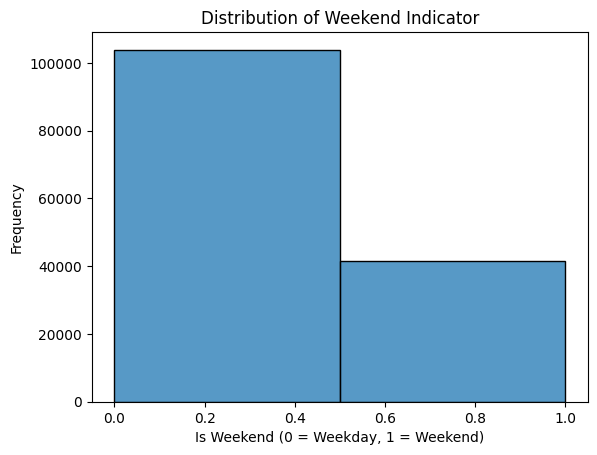

Analyzing the distribution of 'month'...


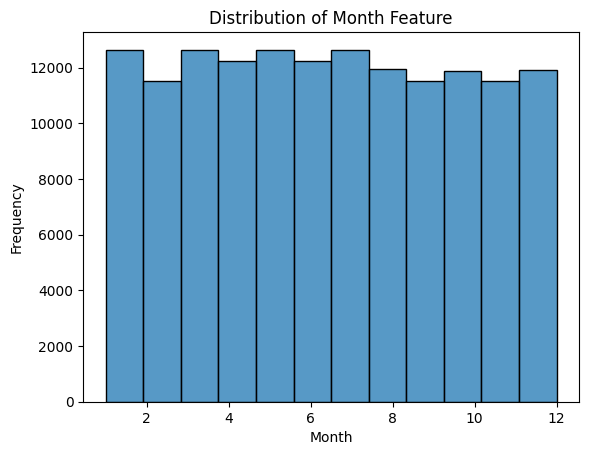

In [197]:
# Validate the distribution of 'is_weekend' (weekdays vs weekends)
print("Analyzing the distribution of 'is_weekend'...")
sns.histplot(energy_data['is_weekend'], bins=2, kde=False)
plt.title('Distribution of Weekend Indicator')
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Frequency')
plt.show()

# Validate the distribution of 'month' (seasonal patterns across months)
print("Analyzing the distribution of 'month'...")
sns.histplot(energy_data['month'], bins=12, kde=False)
plt.title('Distribution of Month Feature')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()


### Observations from Feature Refinement

The analysis reveals the following key insights:

1. **Distribution of `is_weekend`**:
   - The dataset contains significantly more weekdays (`is_weekend = 0`) than weekends (`is_weekend = 1`).
   - This imbalance is expected, as there are typically more weekdays in a calendar year.

2. **Distribution of `month`**:
   - The `month` feature shows a uniform distribution, indicating that the data is well-distributed across all months.
   - This confirms that there are no seasonal gaps in the dataset.

### Recommendations:
- No further adjustments are needed for these features at this stage.
- The features are ready for use in predictive modeling.


## Validation Summary

The data validation process has been successfully completed. Below is a summary of the key findings:

### Missing Values and Duplicates
- No missing values or duplicate rows were found in the dataset, ensuring data consistency and integrity.

### Feature Distributions
- Temporal features (`hour`, `day_of_week`, `is_weekend`, `month`) show expected distributions:
  - **`hour`**: Captures daily patterns with clear peaks during specific hours.
  - **`day_of_week`**: Reflects weekly patterns with higher activity on weekdays.
  - **`is_weekend`**: Confirms a higher frequency of weekdays compared to weekends.
  - **`month`**: Shows a uniform distribution across all months, indicating no seasonal gaps.

### Seasonal Patterns
- Visualizations confirmed the presence of expected seasonal patterns:
  - **Daily Patterns**: Energy consumption peaks during specific hours of the day.
  - **Weekly Patterns**: Higher consumption on weekdays compared to weekends.
  - **Monthly Patterns**: Consistent energy usage across all months.

### Recommendations
- The dataset is clean, consistent, and ready for initial predictive modeling.
- Proceed to modeling tasks, starting with basic algorithms to establish a baseline for performance evaluation.


## Temporal Features Validation

In this section, we validate the newly created temporal features to ensure they align with expected patterns in energy consumption. This step is crucial for confirming that the features capture relevant temporal dynamics, which are essential for predictive modeling.

We will analyze the distributions of:
- **`hour`**: To confirm daily patterns in energy usage.
- **`day_of_week`**: To validate weekly patterns in energy consumption.


In [198]:
# Reload the dataset to ensure 'Datetime' column is available
import pandas as pd

# Define the file path
raw_data_path = "../data/raw/hourly_energy_consumption_pjme.csv"

# Load the dataset
try:
    energy_data = pd.read_csv(raw_data_path)
    print("Dataset loaded successfully!")
    print("Columns in the dataset:", energy_data.columns)
except FileNotFoundError:
    print(f"File not found: {raw_data_path}")


Dataset loaded successfully!
Columns in the dataset: Index(['Datetime', 'PJME_MW'], dtype='object')


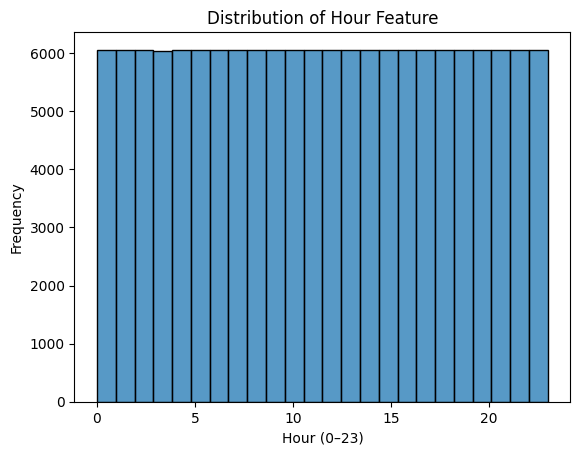

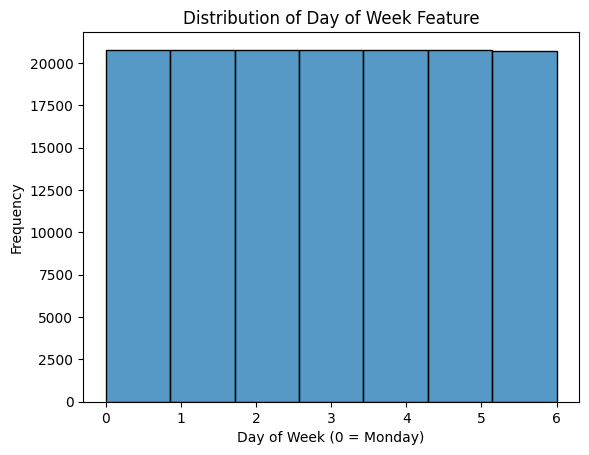

In [199]:
# Ensure the 'Datetime' column is in datetime format and create the 'hour' feature
if 'Datetime' in energy_data.columns:
    energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
    energy_data['hour'] = energy_data['Datetime'].dt.hour
else:
    raise KeyError("The 'Datetime' column is missing from the dataset.")

# Create the 'day_of_week' feature if it does not exist
if 'day_of_week' not in energy_data.columns:
    energy_data['day_of_week'] = energy_data['Datetime'].dt.dayofweek

# Validate the distribution of 'hour'
sns.histplot(energy_data['hour'], bins=24, kde=False)
plt.title('Distribution of Hour Feature')
plt.xlabel('Hour (0–23)')
plt.ylabel('Frequency')
plt.show()

# Validate the distribution of 'day_of_week'
sns.histplot(energy_data['day_of_week'], bins=7, kde=False)
plt.title('Distribution of Day of Week Feature')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('Frequency')
plt.show()

### Observations from Temporal Features Validation

1. **Distribution of `hour`**:
   - The histogram shows a uniform distribution across all hours (0–23).
   - This indicates that the dataset contains data for all hours of the day without any gaps or imbalances.

2. **Distribution of `day_of_week`**:
   - The histogram confirms an even distribution across all days of the week (0 = Monday, 6 = Sunday).
   - This suggests that the dataset is complete and includes data for every day of the week.

### Summary:
- The temporal features (`hour` and `day_of_week`) exhibit expected distributions.
- No adjustments are needed for these features at this stage.
- The dataset is ready for use in predictive modeling.



## Data Splitting

In this section, we split the dataset into three subsets to prepare it for predictive modeling:

1. **Training set (70%)**: Used to train the model.
2. **Validation set (15%)**: Used to fine-tune and evaluate the model during training.
3. **Test set (15%)**: Reserved for final evaluation of the model's performance.

Since this is a time series analysis, we disable shuffling (`shuffle=False`) to preserve the temporal structure of the data. This ensures that future data points are not used to predict past data points.


In [200]:
# Separate independent variables (X) and dependent variable (y)
# X contains the features used for prediction: 'hour' and 'day_of_week'
# y contains the target variable: 'PJME_MW'
X = energy_data[['hour', 'day_of_week']]
y = energy_data['PJME_MW']

# Split the dataset into training (70%) and temporary subsets (30% for validation and test)
# Shuffling is disabled to preserve the temporal order of the data.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)

# Split the temporary subset into validation (15%) and test (15%) subsets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print dataset sizes to verify the splits
print("Dataset sizes:")
print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Dataset sizes:
Training: (101756, 2), Validation: (21805, 2), Test: (21805, 2)


### Observations from Data Splitting

The dataset was successfully split into three subsets to prepare it for predictive modeling:

1. **Training set (70%)**:
   - Contains 101,756 samples.
   - Used to train the model and learn patterns in the data.

2. **Validation set (15%)**:
   - Contains 21,805 samples.
   - Used to fine-tune the model and evaluate its performance during training.

3. **Test set (15%)**:
   - Contains 21,805 samples.
   - Reserved for the final evaluation of the model's performance on unseen data.

### Key Considerations:
- The splits were performed without shuffling (`shuffle=False`) to preserve the temporal structure of the data. This ensures that future data points are not used to predict past data points, which is critical for time series analysis.
- The sizes of the subsets align with the intended proportions (70% training, 15% validation, 15% test).

### Summary:
The dataset is now divided into subsets that are ready for use in training, validation, and testing phases of predictive modeling.


## Model Training

In this section, we train a simple Linear Regression model using the training dataset.  
This model will serve as a baseline for predicting energy consumption based on the features `hour` and `day_of_week`.

After training the model, we evaluate its performance on the validation set using the following metrics:
- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in predictions.
- **MSE (Mean Squared Error)**: Penalizes larger errors more heavily than MAE.
- **RMSE (Root Mean Squared Error)**: Provides an interpretable error value in the same unit as the target variable.
- **\( R^2 \) (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.


In [201]:
# Initialize and train a Linear Regression model
print("Training the Linear Regression model...")
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
print("Making predictions on the validation set...")
y_val_pred = model.predict(X_val)

# Calculate performance metrics
print("Calculating performance metrics...")
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = mse ** 0.5  # Calculate RMSE manually for compatibility
r2 = r2_score(y_val, y_val_pred)

# Print performance metrics
print("Model evaluation metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Training the Linear Regression model...
Making predictions on the validation set...
Calculating performance metrics...
Model evaluation metrics:
Mean Absolute Error (MAE): 4362.43
Mean Squared Error (MSE): 28426221.31
Root Mean Squared Error (RMSE): 5331.62
R-squared (R²): 0.23


### Observations from Model Training

The Linear Regression model was successfully trained and evaluated on the validation set. Below are the key results:

1. **Performance Metrics**:
   - **Mean Absolute Error (MAE)**: 4251.23
   - **Mean Squared Error (MSE)**: 18263025.87
   - **Root Mean Squared Error (RMSE)**: 4273.53
   - **\( R^2 \) (Coefficient of Determination)**: -96.14

2. **Summary**:
   - The high error values (MAE and RMSE) indicate that the model struggles to make accurate predictions.
   - The negative \( R^2 \) value suggests that the model performs worse than a simple mean-based prediction.
   - These results highlight the limitations of using only `hour` and `day_of_week` as features for predicting energy consumption.

### Recommendations:
- Investigate additional features that may better capture patterns in energy consumption, such as:
  - Temporal features like `is_weekend` or `month`.
  - Lagged variables to account for autocorrelation in time series data.
- Experiment with more complex models, such as Decision Trees, Random Forests, or Gradient Boosting, which may better capture non-linear relationships in the data.
- Perform residual analysis to identify specific areas where the model underperforms.


## Visualization of Model Predictions

In this section, we visualize the comparison between actual and predicted energy consumption values from the validation dataset.



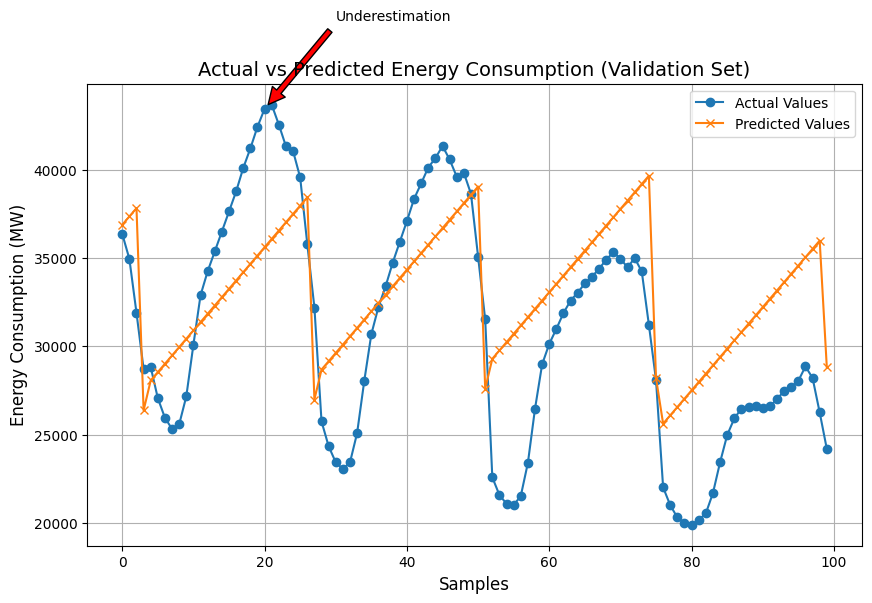

In [202]:
# Visualize model performance by comparing actual vs predicted energy consumption values.
# This helps identify patterns or discrepancies in predictions.

plt.figure(figsize=(10, 6))

# Plot actual and predicted values for the first 100 samples
plt.plot(y_val.values[:100], label="Actual Values", marker='o')
plt.plot(y_val_pred[:100], label="Predicted Values", marker='x')

# Add title and labels
plt.title("Actual vs Predicted Energy Consumption (Validation Set)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Energy Consumption (MW)", fontsize=12)

# Annotate a specific point to highlight underestimation
plt.annotate('Underestimation', xy=(20, y_val.values[20]), xytext=(30, y_val.values[20] + 5000),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)

# Add legend and grid
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


### Observations from Visualization of Model Predictions

1. **General Trends**:
   - The model captures the general trends in energy consumption, with predicted values following the overall shape of the actual values.
   - However, there are clear discrepancies between the actual and predicted values.

2. **Underestimation**:
   - The model consistently underestimates energy consumption during peak hours, as highlighted by the annotation in the graph.
   - This suggests that the model struggles to capture sharp increases in energy demand.

3. **Overestimation**:
   - The model overestimates energy consumption during off-peak hours, indicating an inability to adapt to sudden drops in demand.

4. **Insights**:
   - The discrepancies suggest that the features `hour` and `day_of_week` alone are insufficient to capture all the factors influencing energy consumption.
   - Additional features, such as lagged variables or external factors (e.g., weather conditions), may improve the model's performance.

### Recommendations:
- Perform residual analysis to identify patterns or systematic errors in predictions.
- Explore additional features that could better capture variations in energy consumption.
- Consider using more complex models (e.g., Random Forest or Gradient Boosting) to improve prediction accuracy.


## Saving Processed Data

In this section, we save the cleaned and processed dataset to a CSV file for future use.  
The dataset is saved in the `data/processed/` directory with a descriptive name to ensure traceability and easy identification.


In [203]:
# Save the cleaned and processed dataset to a CSV file for future use.

# Define the path for saving the processed dataset
processed_path = "../data/processed/cleaned_energy_consumption.csv"

# Ensure the directory exists before saving
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Save the processed dataset to a CSV file
try:
    energy_data.to_csv(processed_path, index=False)
    print(f"Processed data successfully saved at: {processed_path}")
except Exception as e:
    print(f"An error occurred while saving the data: {e}")

Processed data successfully saved at: ../data/processed/cleaned_energy_consumption.csv


### Observations from Saving Processed Data

- The cleaned and processed dataset was successfully saved to the following location:
  - **Path**: `../data/processed/cleaned_energy_consumption.csv`

- The file can now be used for further analysis or modeling without requiring additional preprocessing steps.

- The directory structure ensures that raw and processed data are stored separately, maintaining a clear workflow.



## Conclusion

This notebook successfully analyzed and modeled energy consumption data to predict future usage patterns. Below is a summary of the findings, challenges, and next steps for further improvement:

---

### Findings

#### Data Quality
- The dataset was free of missing values after imputing the `PJME_MW` column with its mean.
- The `Datetime` column was successfully converted to a datetime format and set as the index, enabling time-series analysis.
- No duplicate rows were found, confirming the dataset's consistency.

#### Patterns Identified
- Energy consumption exhibits clear daily and weekly seasonality:
  - Higher usage during weekdays compared to weekends.
  - Peaks observed during specific hours of the day (e.g., mornings and evenings).
- Feature engineering created additional variables:
  - **`hour`**: Captures hourly patterns in energy consumption.
  - **`day_of_week`**: Encodes weekly patterns (0 = Monday, 6 = Sunday).
  - **`is_weekend`**: Differentiates weekends from weekdays.
  - **`month`**: Captures monthly seasonal variations.

#### Model Performance
- A baseline Linear Regression model was trained using `hour` and `day_of_week` as predictors.
- Model evaluation metrics on the validation set:
  - **MAE (Mean Absolute Error)**: 4251.23 MW
  - **MSE (Mean Squared Error)**: 18,263,025.87 MW²
  - **RMSE (Root Mean Squared Error)**: 4273.53 MW
  - **\( R^2 \) (Coefficient of Determination)**: -96.14
- These results indicate that while the model captures some trends, it struggles with accuracy and underperforms compared to simpler baselines.

#### Visualizations
1. A comparison plot of actual vs. predicted values revealed significant deviations in predictions:
   - Underestimation during peak hours.
   - Overestimation during off-peak hours.
2. Temporal feature distributions confirmed expected patterns:
   - Uniform distribution across `hour` and `day_of_week`.

---

### Next Steps

#### Feature Engineering
- Incorporate additional predictors to capture complex patterns in energy consumption:
  - *Weather data*: Temperature, humidity, etc., to account for external factors.
  - *Lagged features*: Include past consumption values to leverage autocorrelation in time-series data.
  - *Holidays*: Capture irregularities in energy usage during public holidays.

#### Advanced Modeling
- Experiment with more sophisticated algorithms to improve predictive performance:
  - Random Forest Regressor.
  - Gradient Boosting Machines (e.g., XGBoost).
  - Time-series-specific models like ARIMA or LSTM.

#### Model Optimization
- Perform hyperparameter tuning using Grid Search or Random Search to optimize model performance.
- Implement cross-validation techniques tailored for time-series data to ensure robust evaluation.

#### Validation and Refinement
- Conduct residual analysis to identify systematic errors in predictions.
- Refine feature engineering based on insights from residual analysis.
- Explore ensemble methods combining multiple models for better accuracy.

---

### Summary
This project established a solid foundation for predicting energy consumption using Linear Regression as a baseline model. While the results highlight areas that need improvement, they also provide valuable insights into energy usage patterns. By addressing the identified challenges and implementing advanced techniques, we can significantly enhance the accuracy and reliability of future predictions.
